In [14]:
%%bash
set -e

# (Opcional) silenciar repos ruidosos que no aportan
grep -Rl "r2u.stat.illinois.edu" /etc/apt/sources.list* 2>/dev/null \
  | xargs -r sed -i 's/^[^#].*r2u.stat.illinois.edu.*$/# &/'

# Esperar a que se liberen locks de apt/dpkg (típico en Colab)
tries=0
while fuser /var/lib/dpkg/lock >/dev/null 2>&1 || \
      fuser /var/lib/dpkg/lock-frontend >/dev/null 2>&1 || \
      fuser /var/cache/apt/archives/lock >/devnull 2>&1; do
  echo "apt/dpkg ocupado, esperando..."; sleep 5
  tries=$((tries+1))
  if [ $tries -gt 60 ]; then
    echo "Forzando limpieza de locks..."
    rm -f /var/lib/dpkg/lock-frontend /var/lib/dpkg/lock /var/cache/apt/archives/lock || true
    break
  fi
done

# Reparar dpkg si quedó a medias
dpkg --configure -a || true

# Actualizar con reintentos
apt-get -o Acquire::Retries=3 update -qq

# Instalación INTERMEDIA (recomendada): suficiente para usetex + siunitx + pgf
DEBIAN_FRONTEND=noninteractive apt-get install -y --no-install-recommends \
  texlive-latex-base texlive-latex-recommended texlive-latex-extra \
  texlive-pictures dvipng cm-super ghostscript


Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  cm-super-minimal fonts-lmodern fonts-urw-base35 libapache-pom-java
  libcommons-logging-java libcommons-parent-java libfontbox-java libgs9
  libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java
  libptexenc1 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libzzip-0-13
  pfb2t1c2pfb poppler-data preview-latex-style t1utils tex-common texlive-base
  texlive-binaries
Suggested packages:
  fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x
  libavalon-framework-java libcommons-logging-java-doc
  libexcalibur-logkit-java liblog4j1.2-java poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum
  debhelper perl-tk xpdf | pdf-viewer xzdec texlive-latex-base-doc
  python3-pygments icc-profiles libfile-which-perl
  libspr

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 16,   # 12 * 1.35 ≈ 16
    "font.size": 16,        # 12 * 1.35 ≈ 16
    "legend.fontsize": 15,  # 11 * 1.35 ≈ 15
    "xtick.labelsize": 15,  # 11 * 1.35 ≈ 15
    "ytick.labelsize": 15,  # 11 * 1.35 ≈ 15
    "axes.titlesize": 18    # 13 * 1.35 ≈ 18
})


def cargar_csv(path):
    """Carga un archivo PVGIS (.csv) y devuelve un DataFrame limpio con 8760 horas
    en hora local de Colombia (UTC-5)."""

    # Leer archivo y cortar a 8760 filas (1 año completo)
    df = pd.read_csv(path, skiprows=8).iloc[:8760]

    # Convertir columna de tiempo (originalmente en UTC) y ajustar a Colombia
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')
    df['time'] = df['time'] - pd.Timedelta(hours=5)  # UTC → Colombia

    # Forzar a numérico las columnas físicas
    cols_num = ['Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'Int']
    df[cols_num] = df[cols_num].apply(pd.to_numeric, errors='coerce')

    # Separar fecha y hora locales
    df['date'] = df['time'].dt.date
    df['hour'] = df['time'].dt.time

    # Eliminar columna time (ya no es índice) y resetear índice a entero
    df = df[['date', 'hour'] + cols_num].reset_index(drop=True)

    return df

# Importar explícitamente los 5 datasets
pared_1 = cargar_csv("/content/bases-de-datos/pared_1_azimuth_180_2023.csv")  # Norte
pared_2 = cargar_csv("/content/bases-de-datos/pared_2_azimuth_270_2023.csv")  # Este
pared_3 = cargar_csv("/content/bases-de-datos/pared_3_azimuth_0_2023.csv")    # Sur
pared_4 = cargar_csv("/content/bases-de-datos/pared_4_azimuth_90_2023.csv")   # Oeste
techo   = cargar_csv("/content/bases-de-datos/techo_slope_0_2023.csv")        # Horizontal

# Verificación rápida
print("Pared 1 (Norte):")
print(pared_4.head(), "\n")

Pared 1 (Norte):
         date      hour  Gb(i)  Gd(i)  Gr(i)  H_sun    T2m  WS10m  Int
0  2022-12-31  19:30:00    0.0    0.0    0.0    0.0  14.92   0.14  0.0
1  2022-12-31  20:30:00    0.0    0.0    0.0    0.0  14.47   0.21  0.0
2  2022-12-31  21:30:00    0.0    0.0    0.0    0.0  14.18   0.34  0.0
3  2022-12-31  22:30:00    0.0    0.0    0.0    0.0  13.75   0.14  0.0
4  2022-12-31  23:30:00    0.0    0.0    0.0    0.0  13.29   0.34  0.0 



In [16]:
import numpy as np
import scipy.linalg as la

sigma = 5.67e-8  # Stefan-Boltzmann

def fvm_pared(df, N_nodos=21, L=0.2, k=1.4, rho=2200, c=900,
              eps=0.9, alpha_abs=0.8, h_ext=15, h_int=8,
              T_in=20.0, T_inicial=20.0, dt_sub=10):
    """
    Modelo 1D de transferencia de calor en pared usando volúmenes finitos implícitos.
    Condiciones de borde: convección + radiación linealizada + radiación solar.

    Parámetros
    ----------
    df : DataFrame
        Debe contener ['T2m', 'Gb(i)', 'Gd(i)'] en °C y W/m².
        Cada fila representa 1 hora.
    N_nodos : int
        Número de nodos en la discretización.
    L : float
        Espesor de la pared [m].
    k, rho, c : float
        Propiedades del material.
    eps : float
        Emisividad superficial.
    alpha_abs : float
        Absorptancia solar.
    h_ext, h_int : float
        Coeficientes de convección exterior/interior [W/m²K].
    T_in : float
        Temperatura interior de consigna [°C].
    T_inicial : float
        Temperatura inicial de la pared [°C].
    dt_sub : float
        Paso de integración interna en segundos (subdivisión de cada hora).

    Retorna
    -------
    T_hist : ndarray [n_horas × N_nodos]
        Evolución de la temperatura en todos los nodos [K].
    T_day_int, T_day_ext : arrays
        Temperatura interior y exterior de la pared en cada hora [K].
    carga_termica : array
        Flujo de calor que entra a la casa [W/m²].
    """

    # --- Propiedades y malla ---
    alpha = k / (rho * c)     # difusividad
    delta_x = L / (N_nodos-1) # paso espacial
    a_t = delta_x**2 / (alpha * dt_sub)

    # Estado inicial en K
    T_ini = np.ones(N_nodos) * (T_inicial + 273.15)
    T_in_K = T_in + 273.15

    # Almacenamiento
    n_horas = len(df)
    T_hist = np.zeros((n_horas, N_nodos))
    T_day_int = np.zeros(n_horas)
    T_day_ext = np.zeros(n_horas)
    carga_termica = np.zeros(n_horas)

    # --- Bucle temporal (una iteración por hora de dataset) ---
    for idx, (_, row) in enumerate(df.iterrows()):
        T_aire = row['T2m'] + 273.15      # aire exterior [K]
        T_cielo = T_aire - 6.0            # cielo efectivo [K]
        Gsolar = (row['Gb(i)'] + row['Gd(i)']) * alpha_abs  # solar absorbida

        # Dentro de la hora, subdivisión en pasos dt_sub
        N_times = int(3600 / dt_sub)

        for i in range(N_times):
            # --- Radiación linealizada ---
            hrcielo = eps * sigma * (T_cielo + T_ini[0]) * (T_cielo**2 + T_ini[0]**2)
            hrcasa  = eps * sigma * (T_in_K + T_ini[-1]) * (T_in_K**2 + T_ini[-1]**2)

            # --- Coeficientes base ---
            a_W = np.ones(N_nodos)
            a_P = (-2 - a_t) * np.ones(N_nodos)
            a_E = np.ones(N_nodos)

            # --- Condiciones frontera ---
            # Exterior (nodo 0)
            a_W[0] = 0; a_E[0] = 1
            a_P[0] = -(a_t/2) - (delta_x*(h_ext + hrcielo)/k) - 1

            # Interior (nodo -1)
            a_W[-1] = 1; a_E[-1] = 0
            a_P[-1] = -(a_t/2) - (delta_x*(h_int + hrcasa)/k) - 1

            # --- Vector fuente ---
            S = -a_t * T_ini
            S[0]  = -a_t*T_ini[0]/2 - delta_x*(hrcielo*T_cielo + h_ext*T_aire)/k - (delta_x*Gsolar/k)
            S[-1] = -a_t*T_ini[-1]/2 - delta_x*(h_int*T_in_K + hrcasa*T_in_K)/k

            # --- Matriz banda ---
            Ab = np.zeros((3, N_nodos))
            Ab[0,1:] = a_E[:-1]      # diagonal sup
            Ab[1,:]  = a_P           # diagonal central
            Ab[2,:-1]= a_W[1:]       # diagonal inf

            # --- Resolver sistema implícito ---
            T_new = la.solve_banded((1,1), Ab, S)
            T_ini = T_new.copy()

        # Guardar resultados de la hora
        T_hist[idx,:] = T_ini
        T_day_ext[idx] = T_ini[0]
        T_day_int[idx] = T_ini[-1]
        carga_termica[idx] = (h_int + hrcasa) * (T_ini[-1] - T_in_K)  # W/m²

    return T_hist, T_day_int, T_day_ext, carga_termica


Filas seleccionadas: 24
           date      hour  Gb(i)  Gd(i)  Gr(i)  H_sun    T2m  WS10m  Int
245  2023-01-11  00:30:00    0.0    0.0    0.0    0.0  11.89   0.28  0.0
246  2023-01-11  01:30:00    0.0    0.0    0.0    0.0  11.74   0.34  0.0
247  2023-01-11  02:30:00    0.0    0.0    0.0    0.0  11.52   0.62  0.0
248  2023-01-11  03:30:00    0.0    0.0    0.0    0.0  11.58   0.41  0.0
249  2023-01-11  04:30:00    0.0    0.0    0.0    0.0  11.55   0.48  0.0


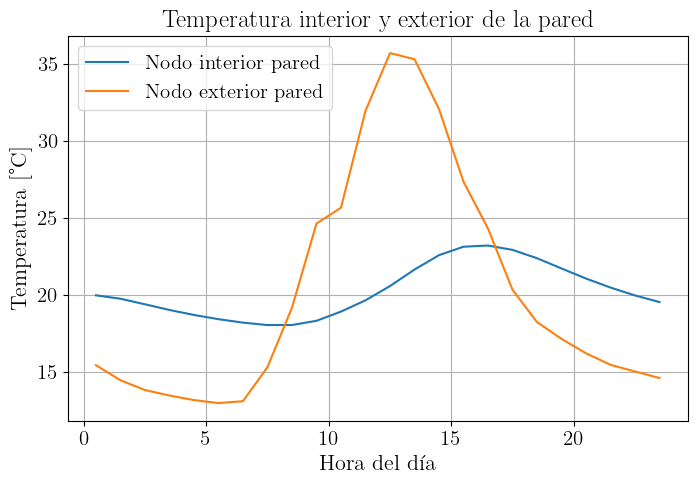

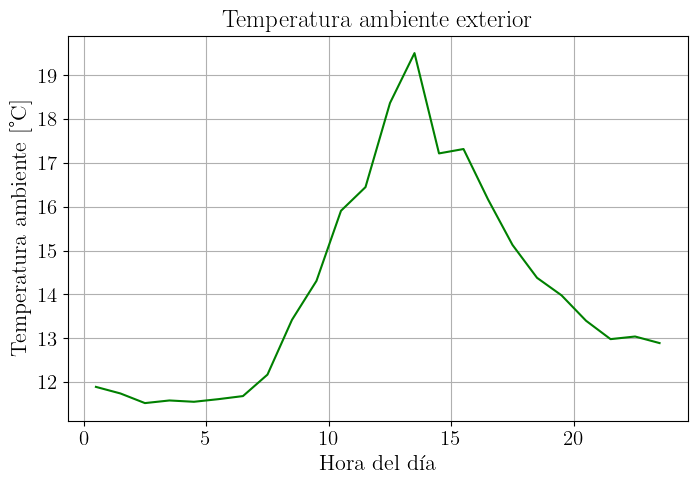

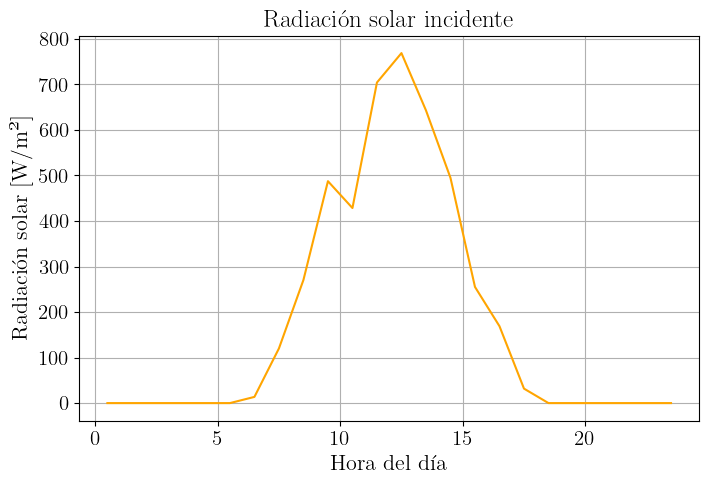

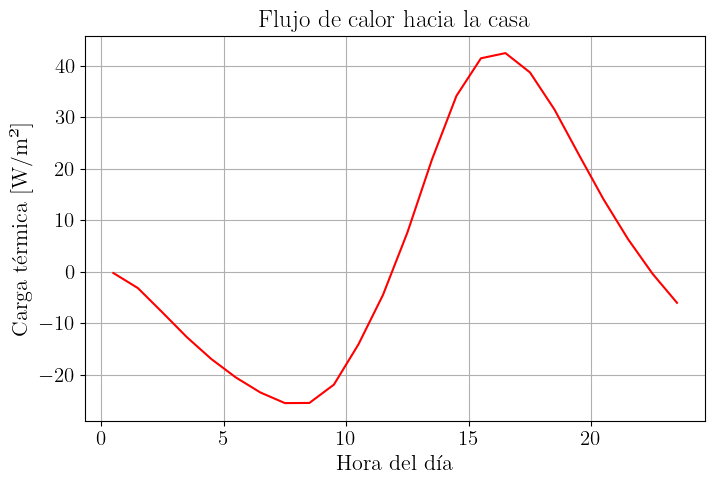

In [17]:
# Seleccionar un día específico (15 de julio 2023)
df_day = techo[techo['date'] == pd.to_datetime("2023-01-11").date()]

print("Filas seleccionadas:", len(df_day))  # debería dar 24 (una fila por hora)
print(df_day.head())

T_hist, T_day_int, T_day_ext, carga_termica = fvm_pared(df_day)

horas = [h + 0.5 for h in range(len(df_day))]  # 0.5, 1.5, 2.5, ... 23.5

# --- 1. Temperaturas interior y exterior de la pared ---
plt.figure(figsize=(8,5))
plt.plot(horas, T_day_int - 273.15, label="Nodo interior pared")
plt.plot(horas, T_day_ext - 273.15, label="Nodo exterior pared")
plt.xlabel("Hora del día")
plt.ylabel("Temperatura [°C]")
plt.title("Temperatura interior y exterior de la pared")
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Temperatura ambiente (dato de entrada) ---
plt.figure(figsize=(8,5))
plt.plot(horas, df_day["T2m"], color="green")
plt.xlabel("Hora del día")
plt.ylabel("Temperatura ambiente [°C]")
plt.title("Temperatura ambiente exterior")
plt.grid(True)
plt.show()

# --- 3. Radiación solar (Gb + Gd) ---
plt.figure(figsize=(8,5))
plt.plot(horas, df_day["Gb(i)"] + df_day["Gd(i)"], color="orange")
plt.xlabel("Hora del día")
plt.ylabel("Radiación solar [W/m²]")
plt.title("Radiación solar incidente")
plt.grid(True)
plt.show()

# --- 4. Carga térmica ---
plt.figure(figsize=(8,5))
plt.plot(horas, carga_termica, color="red")
plt.xlabel("Hora del día")
plt.ylabel("Carga térmica [W/m²]")
plt.title("Flujo de calor hacia la casa")
plt.grid(True)
plt.show()

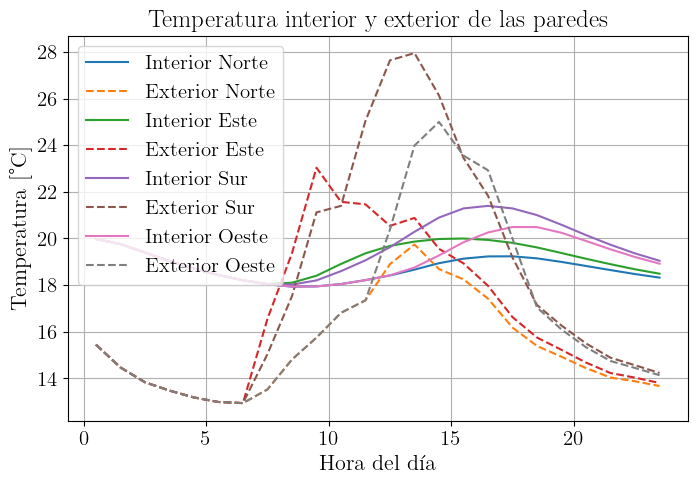

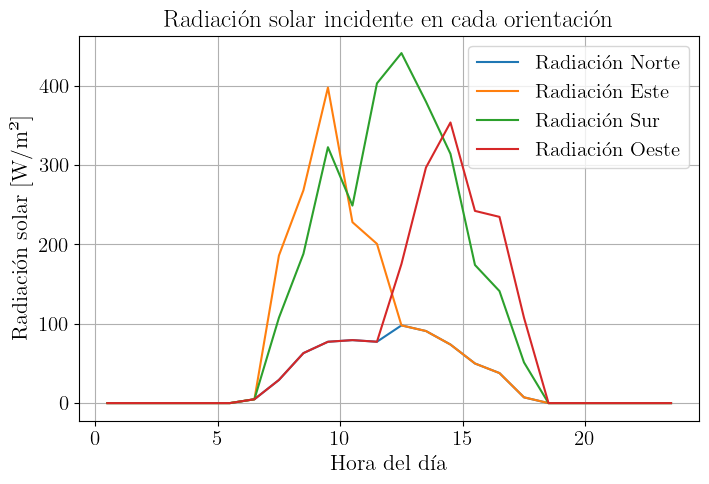

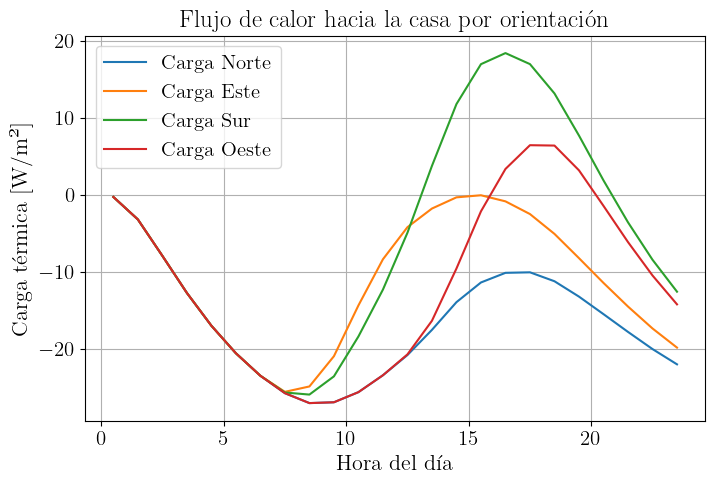

In [18]:
# Diccionario de dataframes con su orientación
paredes = {
    "Norte": pared_1,
    "Este": pared_2,
    "Sur": pared_3,
    "Oeste": pared_4
}

# --- 1. Temperaturas interior y exterior ---
plt.figure(figsize=(8,5))
for orient, df in paredes.items():
    df_day = df[df['date'] == pd.to_datetime("2023-01-11").date()]
    T_hist, T_day_int, T_day_ext, carga_termica = fvm_pared(df_day)
    horas = [h + 0.5 for h in range(len(df_day))]

    plt.plot(horas, T_day_int - 273.15, label=f"Interior {orient}")
    plt.plot(horas, T_day_ext - 273.15, '--', label=f"Exterior {orient}")

plt.xlabel("Hora del día")
plt.ylabel("Temperatura [°C]")
plt.title("Temperatura interior y exterior de las paredes")
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Radiación solar ---
plt.figure(figsize=(8,5))
for orient, df in paredes.items():
    df_day = df[df['date'] == pd.to_datetime("2023-01-11").date()]
    horas = [h + 0.5 for h in range(len(df_day))]
    plt.plot(horas, df_day["Gb(i)"] + df_day["Gd(i)"], label=f"Radiación {orient}")

plt.xlabel("Hora del día")
plt.ylabel("Radiación solar [W/m²]")
plt.title("Radiación solar incidente en cada orientación")
plt.legend()
plt.grid(True)
plt.show()

# --- 4. Carga térmica ---
plt.figure(figsize=(8,5))
for orient, df in paredes.items():
    df_day = df[df['date'] == pd.to_datetime("2023-01-11").date()]
    T_hist, T_day_int, T_day_ext, carga_termica = fvm_pared(df_day)
    horas = [h + 0.5 for h in range(len(df_day))]
    plt.plot(horas, carga_termica, label=f"Carga {orient}")

plt.xlabel("Hora del día")
plt.ylabel("Carga térmica [W/m²]")
plt.title("Flujo de calor hacia la casa por orientación")
plt.legend()
plt.grid(True)
plt.show()


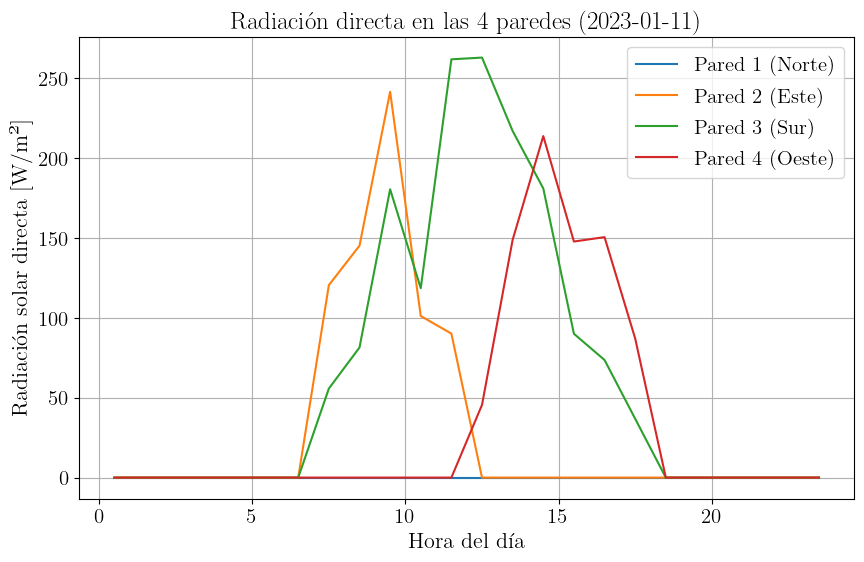

In [19]:
# Seleccionar un día específico (ejemplo: 11 de enero 2023)
dia = pd.to_datetime("2023-01-11").date()

df_p1 = pared_1[pared_1['date'] == dia]
df_p2 = pared_2[pared_2['date'] == dia]
df_p3 = pared_3[pared_3['date'] == dia]
df_p4 = pared_4[pared_4['date'] == dia]

# Eje X: medias horas (0.5, 1.5, ..., 23.5)
horas = [h + 0.5 for h in range(len(df_p1))]

# Graficar radiación directa en cada pared
plt.figure(figsize=(10,6))
plt.plot(horas, df_p1["Gb(i)"], label="Pared 1 (Norte)")
plt.plot(horas, df_p2["Gb(i)"], label="Pared 2 (Este)")
plt.plot(horas, df_p3["Gb(i)"], label="Pared 3 (Sur)")
plt.plot(horas, df_p4["Gb(i)"], label="Pared 4 (Oeste)")

plt.xlabel("Hora del día")
plt.ylabel("Radiación solar directa [W/m²]")
plt.title(f"Radiación directa en las 4 paredes ({dia})")
plt.legend()
plt.grid(True)
plt.show()


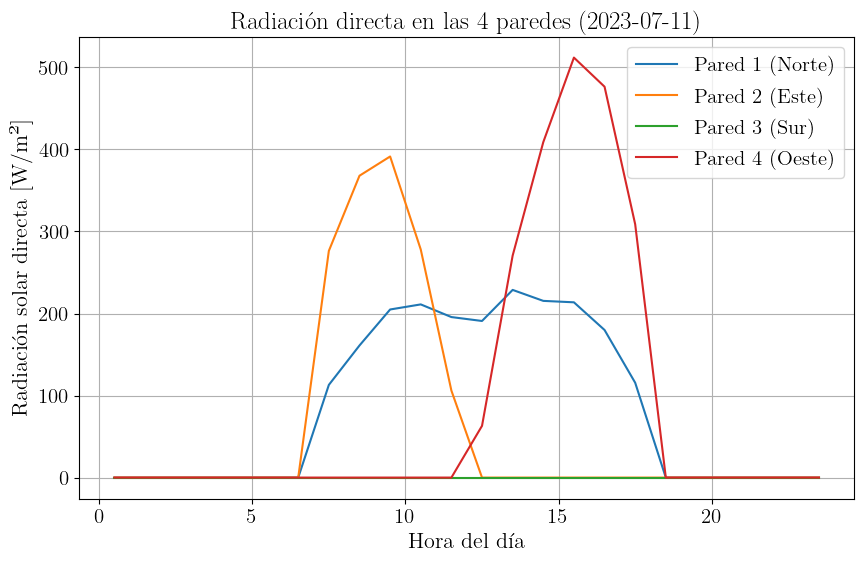

In [20]:
# Seleccionar un día específico (ejemplo: 11 de enero 2023)
dia = pd.to_datetime("2023-07-11").date()

df_p1 = pared_1[pared_1['date'] == dia]
df_p2 = pared_2[pared_2['date'] == dia]
df_p3 = pared_3[pared_3['date'] == dia]
df_p4 = pared_4[pared_4['date'] == dia]

# Eje X: medias horas (0.5, 1.5, ..., 23.5)
horas = [h + 0.5 for h in range(len(df_p1))]

# Graficar radiación directa en cada pared
plt.figure(figsize=(10,6))
plt.plot(horas, df_p1["Gb(i)"], label="Pared 1 (Norte)")
plt.plot(horas, df_p2["Gb(i)"], label="Pared 2 (Este)")
plt.plot(horas, df_p3["Gb(i)"], label="Pared 3 (Sur)")
plt.plot(horas, df_p4["Gb(i)"], label="Pared 4 (Oeste)")

plt.xlabel("Hora del día")
plt.ylabel("Radiación solar directa [W/m²]")
plt.title(f"Radiación directa en las 4 paredes ({dia})")
plt.legend()
plt.grid(True)
plt.show()


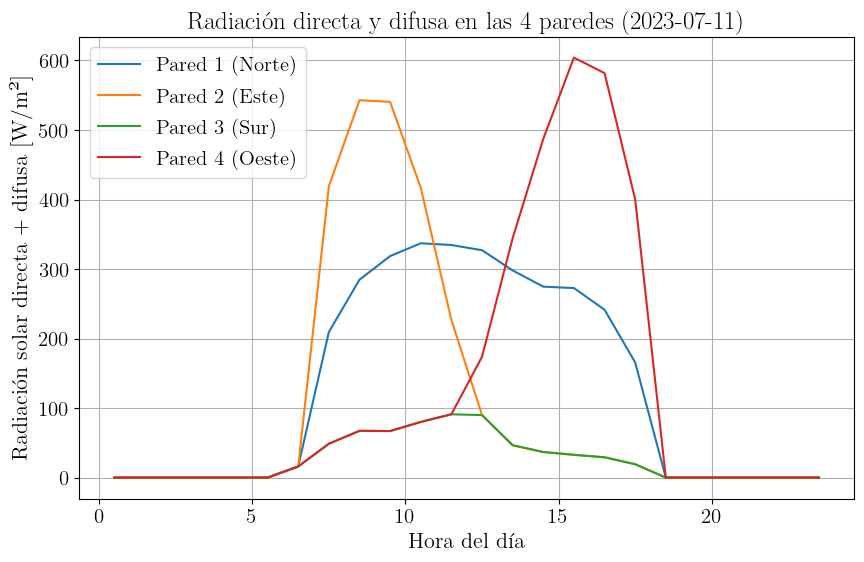

In [21]:
# Seleccionar un día específico (ejemplo: 11 de enero 2023)
dia = pd.to_datetime("2023-07-11").date()

df_p1 = pared_1[pared_1['date'] == dia]
df_p2 = pared_2[pared_2['date'] == dia]
df_p3 = pared_3[pared_3['date'] == dia]
df_p4 = pared_4[pared_4['date'] == dia]

# Eje X: medias horas (0.5, 1.5, ..., 23.5)
horas = [h + 0.5 for h in range(len(df_p1))]

# Graficar radiación directa en cada pared
plt.figure(figsize=(10,6))
plt.plot(horas, df_p1["Gb(i)"] + df_p1["Gd(i)"], label="Pared 1 (Norte)")
plt.plot(horas, df_p2["Gb(i)"] + df_p2["Gd(i)"], label="Pared 2 (Este)")
plt.plot(horas, df_p3["Gb(i)"] + df_p3["Gd(i)"], label="Pared 3 (Sur)")
plt.plot(horas, df_p4["Gb(i)"] + df_p4["Gd(i)"], label="Pared 4 (Oeste)")

plt.xlabel("Hora del día")
plt.ylabel("Radiación solar directa + difusa [W/m²]")
plt.title(f"Radiación directa y difusa en las 4 paredes ({dia})")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
import pandas as pd
import numpy as np

def calcular_areas(Lx, Ly, h=2.5, incluir_piso=False):
    """
    Calcula áreas de paredes y techo de una casa rectangular.

    Parámetros
    ----------
    Lx, Ly : float
        Dimensiones de la planta [m].
    h : float
        Altura de las paredes [m].
    incluir_piso : bool
        Si True, incluye el piso como superficie adicional.

    Retorna
    -------
    dict
        Áreas en m² de cada superficie expuesta.
    """
    areas = {
        "pared_1": Lx * h,   # Norte
        "pared_2": Ly * h,   # Este
        "pared_3": Lx * h,   # Sur
        "pared_4": Ly * h,   # Oeste
        "techo": Lx * Ly     # Techo
    }
    if incluir_piso:
        areas["piso"] = Lx * Ly
    return areas


def obtener_cargas(pared_1, pared_2, pared_3, pared_4, techo,
                   fecha_inicio="2023-01-01", fecha_fin="2023-01-31",
                   N_nodos=21, L=0.2, k=1.4, rho=2200, c=900,
                   eps=0.9, alpha_abs=0.8, h_ext=15, h_int=8,
                   T_in=24.0, dt_sub=60):
    """
    Corre fvm_pared en cada superficie y devuelve un DataFrame con
    las cargas térmicas horarias [W/m²] en el rango de fechas indicado.
    """
    fecha_inicio = pd.to_datetime(fecha_inicio)
    fecha_fin = pd.to_datetime(fecha_fin)

    # Filtrar datasets
    def filtrar(df):
        return df[(pd.to_datetime(df["date"]) >= fecha_inicio) &
                  (pd.to_datetime(df["date"]) < fecha_fin)]

    p1, p2, p3, p4, tc = map(filtrar, [pared_1, pared_2, pared_3, pared_4, techo])

    # Simulación por superficie (con keywords para evitar desorden)
    _, _, _, carga_p1 = fvm_pared(p1, N_nodos=N_nodos, L=L, k=k, rho=rho, c=c,
                                  eps=eps, alpha_abs=alpha_abs,
                                  h_ext=h_ext, h_int=h_int,
                                  T_in=T_in, dt_sub=dt_sub)
    _, _, _, carga_p2 = fvm_pared(p2, N_nodos=N_nodos, L=L, k=k, rho=rho, c=c,
                                  eps=eps, alpha_abs=alpha_abs,
                                  h_ext=h_ext, h_int=h_int,
                                  T_in=T_in, dt_sub=dt_sub)
    _, _, _, carga_p3 = fvm_pared(p3, N_nodos=N_nodos, L=L, k=k, rho=rho, c=c,
                                  eps=eps, alpha_abs=alpha_abs,
                                  h_ext=h_ext, h_int=h_int,
                                  T_in=T_in, dt_sub=dt_sub)
    _, _, _, carga_p4 = fvm_pared(p4, N_nodos=N_nodos, L=L, k=k, rho=rho, c=c,
                                  eps=eps, alpha_abs=alpha_abs,
                                  h_ext=h_ext, h_int=h_int,
                                  T_in=T_in, dt_sub=dt_sub)
    _, _, _, carga_techo = fvm_pared(tc, N_nodos=N_nodos, L=L, k=k, rho=rho, c=c,
                                     eps=eps, alpha_abs=alpha_abs,
                                     h_ext=h_ext, h_int=h_int,
                                     T_in=T_in, dt_sub=dt_sub)

    # Índice temporal (horas exactas)
    # Usar directamente las fechas de los datos filtrados
    fechas = pd.to_datetime(p1["date"]) + pd.to_timedelta(p1.index % 24, unit="h")

    # DataFrame de cargas [W/m²]
    df_cargas = pd.DataFrame({
        "pared_1": carga_p1,
        "pared_2": carga_p2,
        "pared_3": carga_p3,
        "pared_4": carga_p4,
        "techo": carga_techo
    }, index=fechas)

    return df_cargas


def calcular_consumo(df, areas, COP=3.5, costo_kWh=867.8, solo_enfriamiento=True):
    """
    Calcula consumo mensual y anual del AC en kWh y COP$.

    Parámetros
    ----------
    df : DataFrame
        Cargas térmicas [W/m²] por superficie.
    areas : dict
        Áreas en m² de cada superficie.
    COP : float
        Coeficiente de desempeño del aire acondicionado.
    costo_kWh : float
        Precio de la energía [$/kWh].
    solo_enfriamiento : bool
        Si True, solo se contabilizan cargas positivas (calor hacia adentro).

    Retorna
    -------
    mensual, anual : DataFrames
        Resumen de consumos y costos.
    """
    # 1. Carga total horaria (W)
    cargas = [df[surf] * areas[surf] for surf in areas]
    carga_total_W = sum(cargas)

    if solo_enfriamiento:
        carga_total_W = carga_total_W.clip(lower=0)

    # 2. Energía térmica [kWh] (dt = 1h)
    energia_termica_kWh = carga_total_W / 1000.0

    # 3. Energía eléctrica según COP
    energia_electrica_kWh = energia_termica_kWh / COP

    # 4. DataFrame de resultados horarios
    df_result = pd.DataFrame({
        "energia_termica_kWh": energia_termica_kWh,
        "energia_electrica_kWh": energia_electrica_kWh
    }, index=df.index)

    # 5. Resumen mensual y anual
    mensual = df_result.resample("M").sum()
    anual = df_result.resample("Y").sum()

    mensual["costo_COP"] = mensual["energia_electrica_kWh"] * costo_kWh
    anual["costo_COP"] = anual["energia_electrica_kWh"] * costo_kWh

    return mensual, anual


In [23]:
# Definir áreas de la casa
areas = calcular_areas(Lx=5, Ly=5, h=2.5)
print("Áreas [m²]:", areas)

df_cargas = obtener_cargas(
    pared_1, pared_2, pared_3, pared_4, techo,
    fecha_inicio="2023-01-01", fecha_fin="2023-02-01",  # enero completo
    N_nodos=21, L=0.2, k=1.4, rho=2200, c=900,
    h_ext=15, h_int=8, eps=0.9, T_in=24.0, dt_sub=60
)

print(df_cargas.head())


Áreas [m²]: {'pared_1': 12.5, 'pared_2': 12.5, 'pared_3': 12.5, 'pared_4': 12.5, 'techo': 25}
                       pared_1    pared_2    pared_3    pared_4      techo
2023-01-01 05:00:00 -33.632027 -33.632027 -33.632027 -33.632027 -33.632027
2023-01-01 06:00:00 -31.342744 -31.342744 -31.342744 -31.342744 -31.342744
2023-01-01 07:00:00 -32.565541 -32.565541 -32.565541 -32.565541 -32.565541
2023-01-01 08:00:00 -34.809923 -34.809923 -34.809923 -34.809923 -34.809923
2023-01-01 09:00:00 -37.184946 -37.184946 -37.184946 -37.184946 -37.184946


In [24]:
mensual, anual = calcular_consumo(
    df_cargas, areas,
    COP=3.5,               # eficiencia del AC
    costo_kWh=867.8,       # $COP/kWh
    solo_enfriamiento=True # solo consideramos horas con calor hacia adentro
)

print("Resumen mensual:")
print(mensual)

print("\nResumen anual:")
print(anual)


Resumen mensual:
            energia_termica_kWh  energia_electrica_kWh     costo_COP
2023-01-31            81.840275              23.382936  20291.711587

Resumen anual:
            energia_termica_kWh  energia_electrica_kWh     costo_COP
2023-12-31            81.840275              23.382936  20291.711587


/tmp/ipython-input-27569470.py:133: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mensual = df_result.resample("M").sum()
/tmp/ipython-input-27569470.py:134: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  anual = df_result.resample("Y").sum()


In [25]:
# === Bloque 1: utilidades ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calcular_areas(Lx, Ly, h, incluir_piso=False):
    """
    Áreas por orientación y techo.
    Pared_1: azimuth 180 (Norte), Pared_2: 270 (Este), Pared_3: 0 (Sur), Pared_4: 90 (Oeste), Techo: horizontal.
    """
    A_norte = Lx * h   # pared_1 (180)
    A_este  = Ly * h   # pared_2 (270)
    A_sur   = Lx * h   # pared_3 (0)
    A_oeste = Ly * h   # pared_4 (90)
    A_techo = Lx * Ly
    areas = {
        "pared_1_azimuth_180": A_norte,
        "pared_2_azimuth_270": A_este,
        "pared_3_azimuth_0":   A_sur,
        "pared_4_azimuth_90":  A_oeste,
        "techo_slope_0":       A_techo,
    }
    if incluir_piso:
        areas["piso"] = Lx * Ly
    return areas

def empaquetar_superficies(df_pared_1, df_pared_2, df_pared_3, df_pared_4, df_techo):
    """
    Devuelve un dict nombre->DataFrame con los nombres alineados a tus archivos.
    """
    return {
        "pared_1_azimuth_180": df_pared_1,
        "pared_2_azimuth_270": df_pared_2,
        "pared_3_azimuth_0":   df_pared_3,
        "pared_4_azimuth_90":  df_pared_4,
        "techo_slope_0":       df_techo,
    }

def perfil_interpolado(T_hist, time_index, target_ts):
    """
    Devuelve el vector de temperaturas nodales en target_ts.
    Si target_ts no existe exactamente, interpola linealmente entre las dos horas más cercanas.
    - T_hist: ndarray [ntimes, nnodos] (como retorna fvm_pared)
    - time_index: DatetimeIndex de los df (alineado 1:1 con T_hist)
    - target_ts: Timestamp (pd.Timestamp) deseado (ej. '2023-01-01 12:30')
    """
    if target_ts in time_index:
        i = time_index.get_loc(target_ts)
        return T_hist[i, :]
    # buscar vecinos para interpolación
    before = time_index[time_index <= target_ts]
    after  = time_index[time_index >= target_ts]
    if len(before) == 0 or len(after) == 0:
        raise ValueError("target_ts fuera del rango temporal de los datos")
    t0 = before[-1]
    t1 = after[0]
    i0 = time_index.get_loc(t0)
    i1 = time_index.get_loc(t1)
    if t0 == t1:
        return T_hist[i0, :]
    w = (target_ts - t0) / (t1 - t0)  # peso [0,1]
    return (1 - w) * T_hist[i0, :] + w * T_hist[i1, :]

def eje_x_espesor(L, N_nodos):
    """Posiciones a lo largo del espesor (m) para graficar el perfil nodal."""
    return np.linspace(0.0, L, N_nodos)


In [26]:
# === Bloque 2 (fix): costo mensual a 18 °C usando EXACTAMENTE tus nombres ===
# Requiere que existan tus variables: pared_1, pared_2, pared_3, pared_4, techo
# y tus funciones: obtener_cargas, calcular_consumo

import pandas as pd

def _construir_areas_desde_columnas(cols, Lx=5.0, Ly=5.0, h=2.5):
    """
    Construye el dict 'areas' usando las llaves EXACTAS que aparezcan en df_cargas.columns.
    Reglas:
      - pared_1 y pared_3 usan Lx*h
      - pared_2 y pared_4 usan Ly*h
      - techo / techo_slope_0 usa Lx*Ly
    Soporta nombres con o sin sufijos de azimuth/slope.
    """
    areas = {}
    # helpers para detectar por prefijo exacto
    def tiene(col_base):
        return any(c == col_base or c.startswith(col_base + "_") for c in cols)

    # resolver nombre real de cada superficie según exista en columnas
    def nombre_real(base):
        # exacto primero
        if base in cols:
            return base
        # variantes con sufijo (p.ej., base_azimuth_180 o base_slope_0)
        cand = [c for c in cols if c.startswith(base + "_")]
        return cand[0] if cand else None

    # paredes
    n1 = nombre_real("pared_1")
    n2 = nombre_real("pared_2")
    n3 = nombre_real("pared_3")
    n4 = nombre_real("pared_4")
    nt = nombre_real("techo")

    if n1: areas[n1] = Lx * h
    if n3: areas[n3] = Lx * h
    if n2: areas[n2] = Ly * h
    if n4: areas[n4] = Ly * h
    if nt:
        areas[nt] = Lx * Ly
    else:
        # intenta variante 'techo_slope_0'
        nt2 = nombre_real("techo_slope_0")
        if nt2:
            areas[nt2] = Lx * Ly

    if not areas:
        raise KeyError(
            "No se pudo construir el dict de áreas desde las columnas. "
            f"Columnas vistas: {list(cols)}"
        )
    return areas

# 1) Ejecuta tu pipeline para TODO 2023 con setpoint 18 °C
df_cargas = obtener_cargas(
    pared_1, pared_2, pared_3, pared_4, techo,
    fecha_inicio="2023-01-01", fecha_fin="2024-01-01",
    # parámetros FVM (tus mismos)
    N_nodos=21, L=0.2, k=1.4, rho=2200, c=900,
    h_ext=15, h_int=8, eps=0.9, alpha_abs=0.8,
    T_in=18.0, dt_sub=10
)

# 2) Construir ÁREAS con las LLAVES EXACTAS que tiene df_cargas
areas = _construir_areas_desde_columnas(df_cargas.columns, Lx=5.0, Ly=4.0, h=2.5)
print("Áreas [m²] (llaves = columnas reales):", areas)

# 3) Calcular consumo y costo con tus nombres y funciones
mensual, anual = calcular_consumo(
    df_cargas, areas,
    COP=3.5,         # eficiencia del AC
    costo_kWh=867.8, # $COP/kWh
    solo_enfriamiento=True
)

print("== Resumen mensual (18 °C, solo enfriamiento) ==")
display(mensual.assign(costo_COP=mensual["costo_COP"].round(0)))

print("\n== Resumen anual ==")
display(anual.assign(costo_COP=anual["costo_COP"].round(0)))


Áreas [m²] (llaves = columnas reales): {'pared_1': 12.5, 'pared_3': 12.5, 'pared_2': 10.0, 'pared_4': 10.0, 'techo': 20.0}
== Resumen mensual (18 °C, solo enfriamiento) ==


/tmp/ipython-input-27569470.py:133: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  mensual = df_result.resample("M").sum()
/tmp/ipython-input-27569470.py:134: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  anual = df_result.resample("Y").sum()


,energia_termica_kWh,energia_electrica_kWh,costo_COP
2023-01-31,369.785932,105.653124,91686.0
2023-02-28,435.867465,124.533561,108070.0
2023-03-31,291.148356,83.185245,72188.0
2023-04-30,340.563395,97.303827,84440.0
2023-05-31,481.392434,137.540696,119358.0
2023-06-30,567.221743,162.063355,140639.0
2023-07-31,643.098941,183.742554,159452.0
2023-08-31,657.306046,187.801728,162974.0
2023-09-30,632.630249,180.751500,156856.0
2023-10-31,390.894017,111.684005,96919.0



== Resumen anual ==


,energia_termica_kWh,energia_electrica_kWh,costo_COP
2023-12-31,5794.601745,1655.600499,1436730.0
